# MultiAssayExperiment contrasted with tidyverse: Example 1

In this notebook we explore code that depicts a tumor by gene by mutation profile contrast
for selected tumors and genes in Pancancer Atlas.  The Institute for Systems Biology
Cancer Genomics Cloud representation in Google BigQuery consists of denormalized tables
to which it is easy to apply tidy operations, so we start with that.  Then we construct
a MultiAssayExperiment that can be used to make a very similar display.  We conclude with some
discussion.

The basic layout is inspired by the April 5 2018 Cell paper of M. Bailey and colleagues on mutations in cancer.  Expression measures for three genes indicative of immune infiltration are contrasted for substrata defined by a quantification of microsatellite instability for three different tumors.  This leads to a 3 x 3 tableau

# The tidyverse approach

## Setup

We attach some packages and define the tumors and genes of interest.

In [1]:
suppressPackageStartupMessages({library(ggplot2)
library(BiocOncoTK)
library(dplyr)
library(MultiAssayExperiment)
library(ggplot2)
})

tumors = c("COAD", "STAD", "UCEC")
igenes = c("CD8A", "PDCD1", "PDCD1LG2")

To use BigQuery, we need to authenticate.  A billable BigQuery project identifier can be supplied as the optional `billing` parameter to `pancan_BQ`, or the value of environment variable `CGC_BILLING` is used.  The object `bq` below is a `BigQueryConnection` instance that is ready to work with the Annotated dataset of the pancan-atlas project.

In [2]:
bq = pancan_BQ()
bq

<BigQueryConnection>
  Dataset: pancancer-atlas.Annotated
  Billing: vince1-168719

Now we filter and retrieve the data of interest on the genes and tumors of interest.

In [4]:
basic = bq %>% tbl(pancan_longname("RNA")) %>%
            filter(Study %in% tumors, 
                SampleTypeLetterCode == "TP",
                Symbol %in% igenes) %>% as.data.frame(n=Inf)
dim(basic)

[1] 4197    9

We merge MSIsensor scores (Niu et al., Bioinformatics 2014) with this expression data.  It would be nice and tidy if we could join BigQuery table
to a data.frame, but that does not seem to be possible at present.

In [26]:
extrna = left_join(basic, 
                   mutate(BiocOncoTK::dingMSI, 
                          msigt4 = factor(ifelse(MSIsensor.score>4, "MSI>4", "MSI<=4")),
                          ParticipantBarcode=participant_barcode),
                  by="ParticipantBarcode")
dim(extrna[!is.na(extrna$MSIsensor.score),])

[1] 4149   13

Finally, produce the plot.

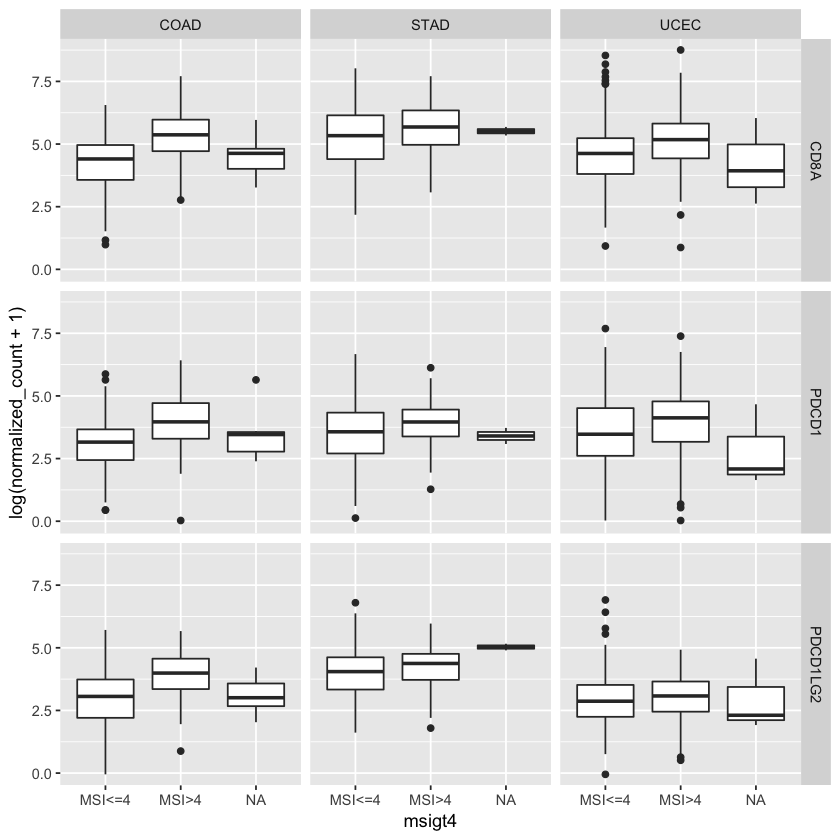

In [6]:
extrna %>% ggplot(aes(x=msigt4, y=log(normalized_count+1))) + 
   geom_boxplot() + facet_grid(Symbol~Study)

# A solution using MultiAssayExperiment


## Construct the MultiAssayExperiment

This employs some high-level interfacing between R and Pancancer Atlas data as managed in Google BigQuery
by Institute of Systems Biology as part of the NCI Cancer Genomics Cloud.  We can reuse `bq` from above.

### The DelayedArray interface to BigQuery denormalized data format

As a quick illustration, we demonstrate how to create a SummarizedExperiment using BigQuery as a DelayedArray back end.


In [7]:
se1 = buildPancanSE(bq, assay="RNASeqv2", acronym="STAD")

Loading required namespace: restfulSE



In [8]:
se1

class: SummarizedExperiment 
dim: 20531 415 
metadata(3): acronym assay sampType
assays(1): assay
rownames(20531): 1 10 ... 9994 9997
rowData names(0):
colnames(415): TCGA-D7-5577 TCGA-FP-A4BF ... TCGA-BR-4361 TCGA-VQ-A8PX
colData names(20): bcr_patient_uuid bcr_patient_barcode ...
  radiation_therapy race

In [9]:
assay(se1)

<20531 x 415> DelayedMatrix object of type "double":
      TCGA-D7-5577 TCGA-FP-A4BF TCGA-IN-A6RR ... TCGA-BR-4361 TCGA-VQ-A8PX
    1   29.5895097   70.4711044   25.6890980   .    25.944829    15.298102
   10    0.2914168    8.0607539    8.7506867   .           NA    23.569053
  100  579.7882273  379.5847979  109.8064879   .   240.038523   118.475183
 1000   14.7628396  211.8365318    3.0727067   .   122.168413     3.406133
10000  170.9487122  540.2069161  252.2348657   .   563.013063    99.705859
  ...            .            .            .   .            .            .
 9991  3933.844360  3181.206919  3833.942650   . 4541.4279123 5225.9396219
 9992     4.131002     7.505554   449.594029   .    0.5581736  112.6078725
 9993  2629.505896  1331.149222  1704.409973   . 1726.8948590 2495.2630698
 9994   292.782943   816.705385   455.302557   .  623.4872758  644.3651088
 9997   859.228083   523.290822   513.489802   .  457.3709988  533.4564758

Of interest are the default usage of Entrez ID as the feature identifier and the existence of missing values.  The DelayedArray code for this transformation of the data is complicated, and it is slow to execute, partly involving dcast operations.  But this is proof of concept only -- more optimizations should be possible.

### Creating a MultiAssayExperiment

We iterate `buildPancanSE` over tumors of interest, filtering genes using `[`.  We also
convert the rownames to gene symbols, and bind the MSIsensor scores in while iterating.

In [10]:
selist = lapply(tumors,
  function(acro) bindMSI(buildPancanSE(bq,
    assay="RNASeqv2", featIDMap=c("RNASeqv2"="Symbol"),
    acronym=acro)))
names(selist) = tumors
mae = MultiAssayExperiment(
  ExperimentList(selist))

This code, though complex, builds a serializable object that includes references to _complete_ expression data tables for three tumors.    We will build the target plot using operations on `mae`. 

In [11]:
mae

A MultiAssayExperiment object of 3 listed
 experiments with user-defined names and respective classes. 
 Containing an ExperimentList class object of length 3: 
 [1] COAD: SummarizedExperiment with 20502 rows and 439 columns 
 [2] STAD: SummarizedExperiment with 20502 rows and 413 columns 
 [3] UCEC: SummarizedExperiment with 20502 rows and 529 columns 
Features: 
 experiments() - obtain the ExperimentList instance 
 colData() - the primary/phenotype DataFrame 
 sampleMap() - the sample availability DataFrame 
 `$`, `[`, `[[` - extract colData columns, subset, or experiment 
 *Format() - convert into a long or wide DataFrame 
 assays() - convert ExperimentList to a SimpleList of matrices

Note that access to the assay quantifications is delayed.

In [13]:
assays(mae)

List of length 3
names(3): COAD STAD UCEC

In [12]:
assay(mae[igenes,], "COAD")

List of length 3
names(3): COAD STAD UCEC

<3 x 439> DelayedMatrix object of type "double":
         TCGA-AY-6386 TCGA-AZ-4682 ... TCGA-AA-3660 TCGA-AA-3975
CD8A          98.4081      43.0019   .     30.91790     56.58268
PDCD1         29.3888       9.8290   .     26.08700     21.84269
PDCD1LG2       8.9057       8.1908   .     18.35750     26.12859

## Creating the plot

We want to use ggplot2 to create our visualization.  This will be easiest with a
denormalized "molten" representation where each number to be plotted has a
separate row.  We'll use nested lapply.


In [14]:
an = as.numeric  # needed to coerce from DelayedArray
dfs = lapply(tumors,
  function(tum) lapply(igenes, function(g)
     data.frame(ParticipantBarcode=colnames(mae)[[tum]], Tumor=tum, Symbol=g, val=log(an(assay(mae[g,], tum))+1),
        msigt4 = factor(ifelse(experiments(mae)[[tum]]$msiTest>4, "msi>4", "msi<=4")))))
thin = do.call(rbind, lapply(dfs, function(x) do.call(rbind, x)))
head(thin)

ParticipantBarcode,Tumor,Symbol,val,msigt4
TCGA-AY-6386,COAD,CD8A,4.599234,msi<=4
TCGA-AZ-4682,COAD,CD8A,3.784233,msi<=4
TCGA-QG-A5Z1,COAD,CD8A,2.277175,msi<=4
TCGA-CM-4750,COAD,CD8A,4.364896,msi<=4
TCGA-AA-A01D,COAD,CD8A,3.765031,msi<=4
TCGA-AA-3976,COAD,CD8A,4.700707,msi<=4


Note that the number of observations is different from that in the tidyverse-oriented approach given above.  `buildPancanSE` insists that every assay-bearing sample have a record in the colData, drawn from the clinical data table.  There are two participants whose RNA/MSIsensor data are used in plots above that have no representation in the MAE.

In [15]:
dim(thin)

[1] 4143    5

The plot is created along the same lines.

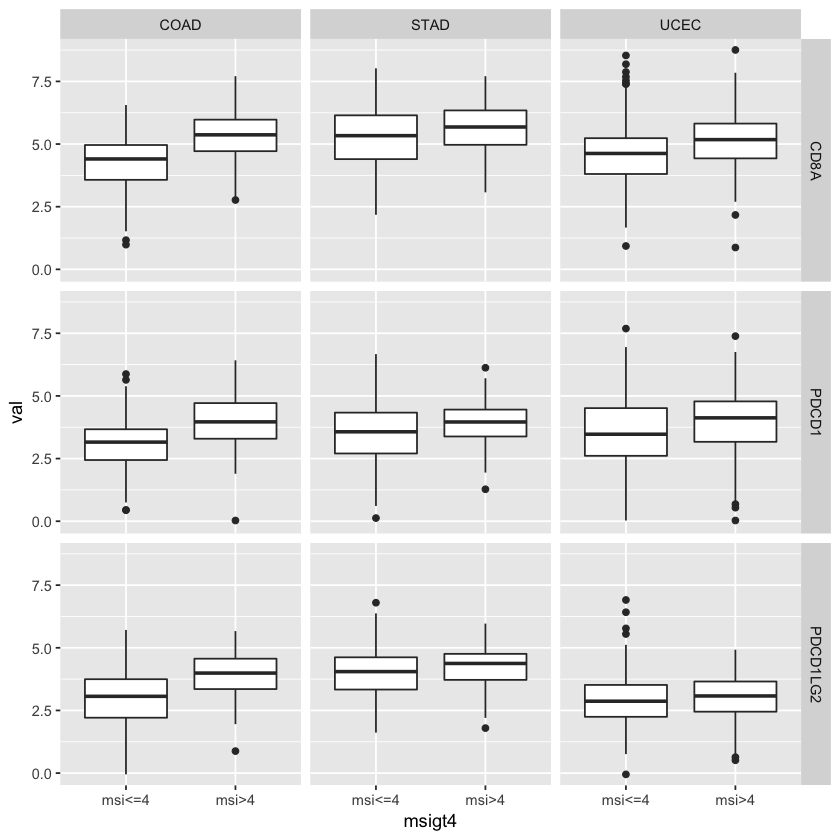

In [16]:
ggplot(thin, aes(msigt4,val)) + geom_boxplot() + facet_grid(Symbol~Tumor)

# Discussion

Given the denormalized format of the basic data resource, the tidyverse code for this task is
appealingly simple.  Again:
```
basic = bq %>% tbl(pancan_longname("RNA")) %>%
            filter(Study %in% tumors, 
                SampleTypeLetterCode == "TP",
                Symbol %in% igenes) %>% as.data.frame(n=Inf)
extrna = left_join(basic, 
                   mutate(BiocOncoTK::dingMSI, 
                          msigt4 = factor(ifelse(MSIsensor.score>4, "MSI>4", "MSI<=4")),
                          ParticipantBarcode=participant_barcode),
                  by="ParticipantBarcode")
```
The MAE-building code is a bit shorter but depends upon helper functions `bindMSI` 
and `buildPancanSE`.
```
selist = lapply(tumors,
  function(acro) bindMSI(buildPancanSE(bq,
    assay="RNASeqv2", featIDMap=c("RNASeqv2"="Symbol"),
    acronym=acro)))
names(selist) = tumors
mae = MultiAssayExperiment(
  ExperimentList(selist))
```
This results in a persistable object whose detailed use depends only on authentication; delayed operations can be applied ad libitum.
```
A MultiAssayExperiment object of 3 listed
 experiments with user-defined names and respective classes. 
 Containing an ExperimentList class object of length 3: 
 [1] COAD: SummarizedExperiment with 20502 rows and 439 columns 
 [2] STAD: SummarizedExperiment with 20502 rows and 413 columns 
 [3] UCEC: SummarizedExperiment with 20502 rows and 529 columns 
Features: 
 experiments() - obtain the ExperimentList instance 
 colData() - the primary/phenotype DataFrame 
 sampleMap() - the sample availability DataFrame 
 `$`, `[`, `[[` - extract colData columns, subset, or experiment 
 *Format() - convert into a long or wide DataFrame 
 assays() - convert ExperimentList to a SimpleList of matrices
 ```


In [27]:
mae[igenes,]

A MultiAssayExperiment object of 3 listed
 experiments with user-defined names and respective classes. 
 Containing an ExperimentList class object of length 3: 
 [1] COAD: SummarizedExperiment with 3 rows and 439 columns 
 [2] STAD: SummarizedExperiment with 3 rows and 413 columns 
 [3] UCEC: SummarizedExperiment with 3 rows and 529 columns 
Features: 
 experiments() - obtain the ExperimentList instance 
 colData() - the primary/phenotype DataFrame 
 sampleMap() - the sample availability DataFrame 
 `$`, `[`, `[[` - extract colData columns, subset, or experiment 
 *Format() - convert into a long or wide DataFrame 
 assays() - convert ExperimentList to a SimpleList of matrices

In [28]:
assay(mae[igenes,]) # defaults to first experiment

Auto-refreshing stale OAuth token.


<3 x 439> DelayedMatrix object of type "double":
         TCGA-AY-6386 TCGA-AZ-4682 ... TCGA-AA-3660 TCGA-AA-3975
CD8A          98.4081      43.0019   .     30.91790     56.58268
PDCD1         29.3888       9.8290   .     26.08700     21.84269
PDCD1LG2       8.9057       8.1908   .     18.35750     26.12859

The example engages the consistency condition of SummarizedExperiments: no assay data without corresponding colData.  This leads to two fewer contributors in the MAE-based application.  This use of ggplot for the exhibition of the contrasts of interest required us to denormalize the (delayed) data in the SummarizedExperiment after normalizing it to create the SummarizedExperiment.